In [4]:
%matplotlib widget

In [5]:
from pinns.prelude import *
from pinns.domain import Sphere
from scipy.stats.qmc import Sobol

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config

In [6]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(10))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(9))
x_bnd = domain.transform_bnd(x_bnd)


In [7]:
def mag(x):
    return array([0., 0., 1.])

l = lambda x: (1 - norm(x) ** 2)

In [8]:

from pinns.elm import elm
from pinns.calc import divergence, laplace
def solve_stray_field(weights):
    W_elm = (weights[:, :3] * 2 - 1) * 1
    b_elm = (weights[:, 3] * 2 - 1) * 1


    def unit_vec(x):
        return x / norm(x, axis=-1, keepdims=True)

    _x_bnd = array(Sobol(2, seed=5123).random_base2(15))
    _x_bnd = domain.transform_bnd(_x_bnd)

    def phi2_solution(x, x_bnd, phi1, l, m):
        eps = 1e-9
        def g(y):
            n = -unit_vec(grad(l)(y))
            return dot(m(y), n) - dot(grad(phi1)(y), n)
        
        dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
        _g = vmap(g)(x_bnd)
        def kernel(dist):
            idx = dist > eps
            newton_kernel = where(idx, 1 / dist, 0.)
            N = jnp.count_nonzero(idx)
            return 1 / N * dot(newton_kernel, _g)

        return vmap(kernel)(dist)

    h_elm = lambda x: tanh(W_elm @ x + b_elm)
    u_elm = lambda x: l(x) * h_elm(x)
    Q_elm = vmap(lambda x: -laplace(u_elm)(x))(x_dom)
    U_elm, S_elm, VT_elm = jax.scipy.linalg.svd(Q_elm, full_matrices=False, lapack_driver="gesvd")
    H_bnd_elm = vmap(h_elm)(x_bnd)
    U_bnd_elm, S_bnd_elm, VT_bnd_elm = jax.scipy.linalg.svd(H_bnd_elm, full_matrices=False, lapack_driver="gesvd")

    def _solve_stray_field(m):
        f = lambda x: -divergence(m)(x)
        b1 = vmap(f)(x_dom)
        params_phi1 = VT_elm.T @ ((1 / S_elm) * (U_elm.T @ b1))
        phi1 = lambda x: u_elm(x) @ params_phi1
        phi_bnd = phi2_solution(x_bnd, _x_bnd, phi1, l, m)
        params_phi_bnd = VT_bnd_elm.T @ ((1 / S_bnd_elm) * (U_bnd_elm.T @ phi_bnd))
        g2 = lambda x: h_elm(x) @ params_phi_bnd
        b2 = vmap(laplace(g2))(x_dom)
        params_phi2 = VT_elm.T @ ((1 / S_elm) * (U_elm.T @ b2))
        phi2 = lambda x: u_elm(x) @ params_phi2 + g2(x)
        phi_nn = lambda x: phi1(x) + phi2(x)
        return phi_nn
    
    return _solve_stray_field(mag)

In [9]:
weights16 = array(Sobol(4, seed=13).random_base2(4))
weights32 = array(Sobol(4, seed=13).random_base2(5))
phi16 = solve_stray_field(weights16)
phi32 = solve_stray_field(weights32)

In [15]:
import matplotlib.pyplot as plt
font = {'family' : 'serif',
    'serif': 'helvet',
    'weight' : 'bold',
    'size' : 12
}

plt.rc('font', **font)
plt.rc('text', usetex=True)

def plot(model, filename=None):
    def plot_result(sol, ax, cbar_label=None):
        plt.sca(ax)
        N = 200
        x = np.linspace(-1, 1, N)
        z = np.linspace(-1, 1, N)
        X = np.array([_x for _x in itertools.product(x, z)])
        _X = jnp.asarray(X)
        _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
        phi = np.array(sol(_X))
        phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

        p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("YlOrRd"), alpha=0.5)
        cbar = plt.colorbar(p)
        if cbar_label is not None:
            cbar.set_label(cbar_label)
        
        ax.set_xlabel(r"$x_1$")
        ax.set_ylabel(r"$x_3$")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        # ax.axis('off')

    def plot_model(model):
        fig = plt.figure(figsize=(8, 3))
        fig.tight_layout()
        ax1, ax2 = fig.subplots(1, 2)
        fig.subplots_adjust(wspace=0.4)
        plot_result(model, ax1, cbar_label=r"$\hat \phi$")
        #ax1.set_title("ELM", size=14)
        
        ax1.set_aspect('equal', 'box')
        plot_result(lambda x: abs(model(x) - x[..., 2] / 3), ax2, cbar_label=r"$|\hat \phi - \phi^{int}|$")
        #ax2.set_title("Absolute error", size=14)
        ax2.set_xlabel(r"$x_1$")
        ax2.set_ylabel(r"$x_3$")
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.set_aspect('equal', 'box')
        fig.tight_layout()
        return fig
    
    fig = plot_model(vmap(model))
    if filename is not None:
        fig.savefig(filename)

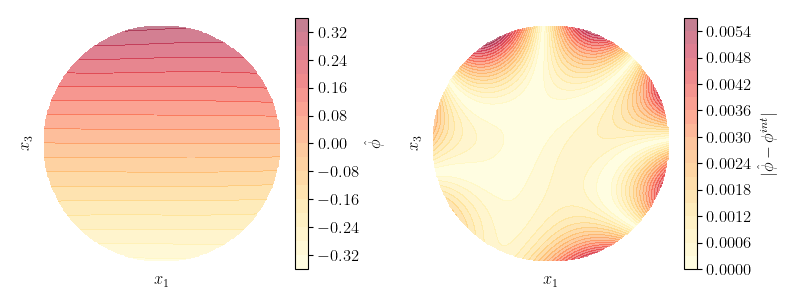

In [16]:
#plot(phi16)
plot(phi16, "sphere_unit_mag_16.pdf")

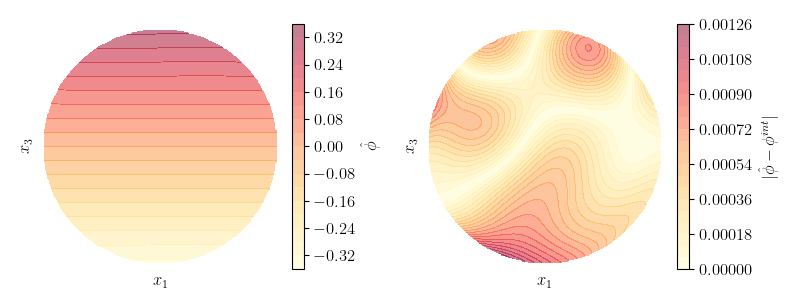

In [17]:
#plot(phi32)
plot(phi32, "sphere_unit_mag_32.pdf")

In [13]:
def ed(model, x):
    Ms = 1.
    H = lambda x: -grad(model)(x)
    e = lambda x: dot(mag(x), H(x)) 
    return -jnp.sum(vmap(e)(x)) / len(x) * pi / 3

In [14]:
print(f"mag energy for 16 nodes {ed(phi16, x_dom):.4}")
print(f"mag energy for 32 nodes {ed(phi32, x_dom):.4}")
print(f"True mag energy {pi / 9:.4}")

mag energy for 16 nodes 0.3486
mag energy for 32 nodes 0.3487
True mag energy 0.3491
